In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import add_messages
from ollama import chat
from langchain_core.messages import AIMessage
from langgraph.checkpoint.memory import MemorySaver
import re
from pydantic import BaseModel, Field
from pydantic import ValidationError
import json


In [12]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    # messages: List[dict]

In [13]:
class ResponseSchema(BaseModel):
    response : int = Field(gt=0)

In [14]:
import re
from ollama import chat

def chat_node(state: ChatState) -> ChatState:
    messages = state["messages"]
    print(messages)
    # Convert BaseMessage → Ollama dicts only for the API
    messages_dicts = []
    for m in messages:
        if isinstance(m, HumanMessage):
            messages_dicts.append({"role": "user", "content": m.content})
        elif isinstance(m, AIMessage):
            messages_dicts.append({"role": "assistant", "content": m.content})

    # Call Ollama
    response = chat(
        model="deepseek-r1:1.5b",
        messages=messages_dicts
    )

    clean_text = re.sub(r"<think>.*?</think>", "", response["message"]["content"], flags=re.DOTALL).strip()
    
    try:
        structured_data = json.loads(clean_text)
        validated_output = ResponseSchema(**structured_data)
    except (json.JSONDecodeError, ValidationError) as e:
        # Fallback if parsing/validation fails
        validated_output = ResponseSchema(response=1)  # default/fallback
        print("Warning: invalid output from model:", clean_text)
        print("Error:", e)

    # Append assistant response as AIMessage to the state
    updated_messages = messages + [AIMessage(content=clean_text)]

    return {"messages": updated_messages}


In [15]:
graph = StateGraph(ChatState)
checkpointer = MemorySaver()

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

workflow = graph.compile(checkpointer= checkpointer)



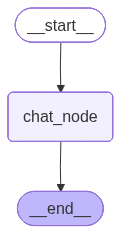

In [93]:
workflow

In [19]:
state: ChatState = {"messages": []}
thread_id = '1'
config = {'configurable' : {'thread_id' : thread_id}}
state: ChatState = {
    "messages": [
        SystemMessage(content="You are a calculator assistant. Always reply in JSON: {\"response\": <integer>}")
    ]
}
state = workflow.invoke(state, config=config)
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break

    # Add user message
    state["messages"].append(HumanMessage(content=user_input))

   
    # Run chat node
    state = workflow.invoke({'messages': [HumanMessage(content=user_input)]}, config=config)

    print("Assistant:", state["messages"][-1].content)


state = {"messages": []}


[SystemMessage(content='You are a calculator assistant. Always reply in JSON: {"response": <integer>}', additional_kwargs={}, response_metadata={}, id='f1235b8b-71e1-4e6b-9f8b-a61f01d91ab3'), SystemMessage(content='You are a calculator assistant. Always reply in JSON: {"response": <integer>}', additional_kwargs={}, response_metadata={}, id='408e2c34-6063-4219-9779-2a0b65d80a17'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='c347eb89-4b63-42c9-903e-7d2d840eb697', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='what is capital of pakistan', additional_kwargs={}, response_metadata={}, id='5296502d-2932-40ba-8c0a-0e8c9bb7d87f'), AIMessage(content='The capital of Pakistan is Quaid-e-Azam University in Islamabad. The city of Islamabad, also known as Quetta, is the largest and most populous city in Pakistan and serves as the administrative center of the country. Quaid-e-Azam University, located on the banks of the Yangtze River, is a prominent institution

In [9]:
thread_id = '1'
config = {'configurable' : {'thread_id' : thread_id}}

state: ChatState = {
    "messages": [
        SystemMessage(content="You are a calculator assistant. Always reply in JSON: {\"response\": <integer>}")
    ]
}
state = workflow.invoke(state, config=config)

print("Assistant:", state["messages"][-1].content)


[SystemMessage(content='You are a calculator assistant. Always reply in JSON: {"response": <integer>}', additional_kwargs={}, response_metadata={}, id='01b26529-6553-4922-a20d-ede659573a20'), SystemMessage(content='You are a calculator assistant. Always reply in JSON: {"response": <integer>}', additional_kwargs={}, response_metadata={}, id='a9f78d61-7e00-4396-86c7-aea26b9cd1d9')]


ValidationError: 1 validation error for ResponseSchema
reponse
  Field required [type=missing, input_value={'response': 0}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In [33]:
import re

user_input = "What is capital city of China"
response = chat(
    model='deepseek-r1:1.5b',
    messages=[
        {'role': 'user', 'content': user_input}
    ]
)


text = response['message']['content']

# Remove <think>...</think>
clean_text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()

print(clean_text)

The capital of China is Beijing.


In [20]:
from ollama import chat

print("Chat started. Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break

    print("Model: ", end="", flush=True)
    for chunk in chat(
        model="deepseek-r1:1.5b",
        messages=[{"role": "user", "content": user_input}],
        stream=True,
    ):
        print(chunk["message"]["content"], end="", flush=True)

    print("\n")


Chat started. Type 'exit' to quit.



In [12]:
from langchain_ollama import OllamaEmbeddings

# 1️⃣ Setup Ollama embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"  # make sure Ollama is running
)

# 2️⃣ Example input text
texts = [
    "The capital of Pakistan is Islamabad.",
    "Karachi is the largest city in Pakistan.",
    "Lahore is famous for its culture and food."
]

# 3️⃣ Generate embeddings
embeddings_list = embeddings.embed_documents(texts)

# 4️⃣ Print results
for text, vec in zip(texts, embeddings_list):
    print(f"Text: {text}")
    print(f"Embedding length: {len(vec)}")
    print(f"First 10 dims: {vec[:10]}")
    print("---")

# 5️⃣ Generate embedding for a single query
query = "What is the capital of Pakistan?"
query_vec = embeddings.embed_query(query)
print("Query embedding length:", len(query_vec))
print("First 10 dims:", query_vec[:10])


Text: The capital of Pakistan is Islamabad.
Embedding length: 768
First 10 dims: [0.044499103, 0.030817926, -0.1261774, -0.031899728, 0.057978775, 0.06341333, -0.012656392, -0.0019015451, 0.045389988, -0.016721562]
---
Text: Karachi is the largest city in Pakistan.
Embedding length: 768
First 10 dims: [0.051595964, 0.05329536, -0.12304631, 0.0041261516, 0.013333, 0.07576696, -0.0065881955, 0.029670743, 0.023827173, 0.0047604693]
---
Text: Lahore is famous for its culture and food.
Embedding length: 768
First 10 dims: [0.047556993, 0.06994749, -0.17465745, 0.017788101, -0.0015293012, -0.005974245, -0.048852835, -0.0060100565, 0.02301357, -0.023574123]
---
Query embedding length: 768
First 10 dims: [0.040670663, 0.011320926, -0.1067975, -0.0025148955, 0.05350603, 0.03848292, -0.028616995, -0.004668292, 0.02696397, -0.008000452]
